# Интеллектуальный анализ данных – весна 2022

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [ ]:
#  ༼つಠ益ಠ༽つ ─=≡ΣO))

def find_H(k1, k2):
    p1 = k1 / (k1 + k2)
    p2 = k2 / (k1 + k2)
    return -(p1 * np.log(p1) + p2 * np.log(p2))

k1, k2 = 8, 2

ans = round(find_H(k1, k2), 2)
ans

0.5

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

---

**Ans:**

Формула выше значительно упрощается, так как $\sum_{k} p_k = 1$ и поэтому
$$
H(R) = \sum_{k=1}^J p_k(1-p_k) = 1 - \sum_{k=1}^J p_k^2
$$

Так как множество $R_{\ell}$ состоит только из объектов класса $k_1$, а множество $R_{r}$ состоит только из объектов класса $k_2$, то $H(R_{\ell}) = H(R_{r}) = 0$ и поэтому ответ совпадает с $H(R_m)$

In [ ]:
ans

0.5

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

---

**Ans:**

В дереве (в листе) мы рассматриваем самый простой способ предсказания значения для объектов попавших в один лист (константу), поэтому в задаче регрессии мы используем среднее значение целевой переменной всех объектов, попавших в данный лист

In [ ]:
np.mean([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])

40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [ ]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании (нет :))).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За [имплементацию без цикла](https://academy.yandex.ru/handbook/ml/article/reshayushchiye-derevya#dinamicheskoe-programmirovanie) – **бонус 1 балл**.

---
Будем считать (см. задание 1.2), что у нас задача регрессии или *бинарной* классификации

Для задачи регрессии будем использовать следующие определения:

$$
\overline{Y} = \frac1N\sum y_i \\
\sigma^2 (Y) = \overline{Y^2} - (\overline{Y})^2 = \frac1N\sum y_i^2 - \frac{1}{N^2}(\sum y_i)^2
$$

 Нам необходимо и достаточно для каждого потенциального значения сплита знать количество элементов в правом и левом поддеревьях, их сумму и сумму их квадратов (на самом деле всё это необходимо знать только для одной из половинок сплита, а для второй это можно получить, вычитая значения для первой из полных сумм). Это можно сделать за один проход по массиву, просто накапливая значения [частичных сумм](https://numpy.org/doc/stable/reference/generated/numpy.cumsum.html).

 Для категориальных признаков работу тоже можно упростить, не перебирая все его уникальные значения ([так проще](https://academy.yandex.ru/handbook/ml/article/reshayushchiye-derevya#kategorialnye-priznaki)), НО только для задач бинарной классификации и задач регрессии с MSE-функционалом. В общем случае такого, конечно, нельзя сделать и придется перебирать все уникальные значения.

 [Тут лучше](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf)

In [ ]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    if feature_type == "categorical":
        df0 = pd.DataFrame({'cat_f': feature_vector, 'Tár': target_vector})

        if task == "classification": # classification with categorical feature
            c = df0.groupby(['cat_f']).agg(lambda S: np.sum(S.values[np.where(S == 1)]) / len(S)).sort_values(by=['Tár'])['Tár'].index.tolist()
    
        else:  # regression with categorical feature
            c = df0.groupby(['cat_f']).mean().sort_values(by=['Tár'])['Tár'].index.tolist()
        
        feature_vector = df0['cat_f'].map({w: i for i, w in enumerate(c)}).values

    all_data = np.hstack((feature_vector.reshape(-1, 1), target_vector.reshape(-1, 1)))
    all_data = all_data[all_data[:, 0].argsort()]

    feature_vector = all_data[:, 0]
    target_vector = all_data[:, 1]

    thresholds = np.sort(feature_vector)
    thresholds = (thresholds[1:] + thresholds[:-1]) / 2.0
    
    left_cumulative_sum = np.cumsum(target_vector)[:-1]
    right_cumulative_sum = np.flip(np.cumsum(np.flip(target_vector)))[1:]
    
    left_count = np.arange(1, len(feature_vector))
    right_count = np.arange(len(feature_vector) - 1, 0, -1)
    
    # print(left_count, right_count, left_cumulative_sum, right_cumulative_sum)
    if task == "classification": # binary
        # for node: H(R) = 1 - p1^2 - p2^2 = /p2 = 1 - p1/ =2p1(1 - p1) 
        left_gini = 2 * left_cumulative_sum * (left_count - left_cumulative_sum) / left_count**2
        right_gini = 2 * right_cumulative_sum * (right_count - right_cumulative_sum) / right_count**2

        ginis = (left_count * left_gini + right_count * right_gini) / len(feature_vector)

        best_index = np.argmin(ginis)
        threshold_best = thresholds[best_index]
        gini_best = ginis[best_index]

        return thresholds, ginis, threshold_best, gini_best

    # regression
    left_variance = left_cumulative_sum**2 / left_count - (left_cumulative_sum / left_count)**2
    right_variance = right_cumulative_sum**2 / right_count - (right_cumulative_sum / right_count)**2
    variances = (left_count * left_variance + right_count * right_variance) / len(feature_vector)

    best_index = np.argmin(variances)
    threshold_best = thresholds[best_index]
    variance_best = variances[best_index]

    return thresholds, variances, threshold_best, variance_best

Эту функцию можно протестировать на датасете `California`.

In [ ]:
from sklearn.datasets import fetch_california_housing

In [ ]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [ ]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
thrs, gns, *_ = find_best_split(X['MedInc'].values, y, task="regression", feature_type="real")

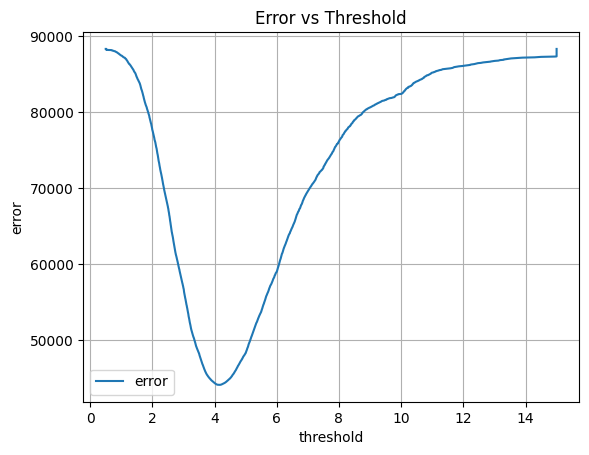

In [ ]:
plt.plot(thrs, gns, label="error")
plt.xlabel("threshold")
plt.ylabel("error")
plt.legend()
plt.grid()
plt.title("Error vs Threshold")
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

Best columns for first node is MedInc
Best threshold is 4.145


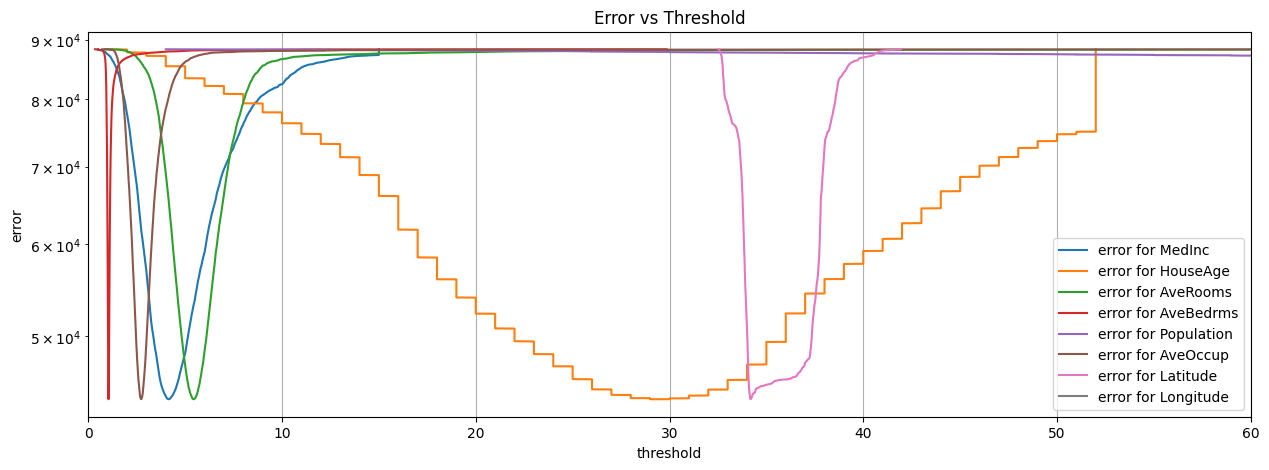

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
plt.figure(figsize=(15, 5))
ans = np.inf
for col in X.columns:
    thrs, gns, best_thr, best_c = find_best_split(X[col].values, y, task="regression", feature_type="real")
    plt.plot(thrs, gns, label=f"error for {col}")

    if best_c < ans:
        ans = best_c
        best_col = col
        best_t = best_thr

print(f'Best columns for first node is {best_col}')
print(f'Best threshold is {best_t}')
plt.xlabel("threshold")
plt.ylabel("error")
plt.grid()
plt.legend()
plt.xlim(0, 60)
# plt.xlim(0, 2**10)
plt.yscale("log")
plt.title("Error vs Threshold")
plt.show()

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

Немного видоизменил код, и сделал бонусы.

In [ ]:
class DecisionTree:
    def __init__(self, feature_types, max_depth=11, min_samples_split=0, min_samples_leaf=0):
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        self._tree = {}
        self._feature_types = feature_types
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split  # the min number that requierd to split the node
        self._min_samples_leaf = min_samples_leaf # if only after split we get the node with the less number of nodes than this number we cancel the split (in the code just return the most frequent label and don't go fether)

    def get_params(self, deep=False):
        return {
            "feature_types": self._feature_types,
            "max_depth": self._max_depth,
            "min_samples_split": self._min_samples_split,
            "min_samples_leaf": self._min_samples_leaf,
        }
    
    def _fit_node(self, sub_X, sub_y, node, depth, samples_split):
        sub_X = np.array(sub_X)
        sub_y = np.array(sub_y)

        if depth >= self._max_depth or samples_split < self._min_samples_split:
            node['type'] = 'terminal'
            node['counts'] = len(sub_y)
            node['class'] = Counter(sub_y).most_common(1)[0][0]
            return

        # критерий останова: пока в листе есть объекты с различным таргетом продолжаем делить их 
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"  # it means that this node is a leaf node
            node['counts'] = len(sub_y)
            node["class"] = sub_y[0] # in this node all the targets are the same and has sub_y[0] as class
            return

        # from here we starting to choose the best feature and its split for samples in this node to split after
        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(1, sub_X.shape[1]):  # goes through all the features
            feature_type = self._feature_types[feature]  # gets the type of the feature (it can only be real or categorical)
            categories_map = {}

            if feature_type == "real":
                feature_vector = sub_X[:, feature] # gets the feature vector (the array of numbers) from matrix sub_X

            elif feature_type == "categorical":
                counts = Counter(sub_X[:, feature])  # counts (dict) the number of occurrences of each category in the feature vector
                clicks = Counter(sub_X[sub_y == 1, feature])  # objects in feature vector that have sub_y == 1
                ratio = {}

                for key, current_count in counts.items():
                    current_click = clicks[key] if key in clicks else 0
                    ratio[key] = current_click / current_count

                sorted_categories = list(map(lambda x: x[0], sorted(ratio.items(), key=lambda x: x[1]))) # sorts categories by their ratios values; it is the list of sorted categories
                categories_map = dict(

                    zip(sorted_categories, list(range(len(sorted_categories))))

                    ) # maps the sorted categories to their indices: {ratio of categorcal value: its index}

                # coding all categorical feature to numeric using the ratio of each category
                feature_vector = np.array(

                    list(map(lambda x: categories_map[x], sub_X[:, feature]))

                    ) # sub_X[:, feature] contains the categorical features; returns the indexes of each category based on the sorted ratio values
                # feature_vector is an array of nums
            else:
                raise ValueError

            # print(Counter(feature_vector))
            # print(Counter(sub_y))
            _, _, threshold, gini = find_best_split(feature_vector, sub_y)

            if gini_best is None or gini < gini_best:
                feature_best = feature  # feature is the number of the feature
                gini_best = gini
                split = feature_vector < threshold # the boolean mask of split using the threshold as the split value

                if feature_type == "real":
                    threshold_best = threshold
                elif feature_type == "categorical":
                    threshold_best = list(
                            map(
                                lambda x: x[0],
                                filter(lambda x: x[1] < threshold, categories_map.items())
                                )
                        )
                else:
                    raise ValueError

        # we went through the all features and tried to find best split among all features
        if (feature_best is None) or \
            (np.any(np.unique(split, return_counts=True)[-1] < self._min_samples_leaf)) or \
            (len(sub_y[split]) == 0 or len(sub_y[np.logical_not(split)]) == 0): # all samples goes to one child so we make this node as the child node

            node["type"] = "terminal"
            node['counts'] = len(sub_y)
            node["class"] = Counter(sub_y).most_common(1)[0][0] # chose the most frequent class
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["categories_split"] = threshold_best
        else:
            raise ValueError

        
        # make the same things for left and right child
        node["left_child"], node["right_child"] = {}, {}

        self._fit_node(
            sub_X[split],
            sub_y[split],
            node["left_child"],
            depth + 1,
            len(sub_y[split])
            )
        
        self._fit_node(
            sub_X[np.logical_not(split)],
            sub_y[np.logical_not(split)],
            node["right_child"],
            depth + 1,
            len(np.logical_not(sub_y[split]))
            )


    def _predict_node(self, x, node): # x is the object (x.shape = (1, len(features)))
        while node['type'] == 'nonterminal':
            if node["type"] == "nonterminal":
                if 'categories_split' in node:
                    if x[node["feature_split"]] in node["categories_split"]:
                        node = node["left_child"]
                    else:
                        node = node["right_child"]
                elif 'threshold' in node:
                    if x[node["feature_split"]] < node["threshold"]:
                        node = node["left_child"]
                    else:
                        node = node["right_child"]
        
        return node["class"]


    def fit(self, X, y):
        self._fit_node(X, y, self._tree, 1, len(y))

    def tree_data(self):
        return self._tree
        
    def predict(self, X):
        predicted = []
        for x in np.array(X):
            pred_node = self._predict_node(x, self._tree)
            predicted.append(pred_node)
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [ ]:
df = pd.read_csv('students.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True) # ну кто же сохраняет данные без удаления индексов ... :(
df.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


In [ ]:
df.describe()

,STG,SCG,STR,LPR,PEG,UNS
count,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000
mean,0.371147,0.355674,0.468004,0.432713,0.458539,0.585271
std,0.210271,0.211962,0.245940,0.248108,0.255211,0.493633
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.240750,0.210000,0.291250,0.250000,0.250000,0.000000
50%,0.327000,0.302500,0.490000,0.330000,0.500000,1.000000
75%,0.495000,0.497500,0.690000,0.647500,0.660000,1.000000
max,0.990000,0.900000,0.950000,0.990000,0.930000,1.000000


In [ ]:
df['UNS'].value_counts()

1    151
0    107
Name: UNS, dtype: int64

In [ ]:
X = df.drop(['UNS'], axis=1)
y = df['UNS'].values

Best split feature for first node is PEG
Best threshold is 0.3365


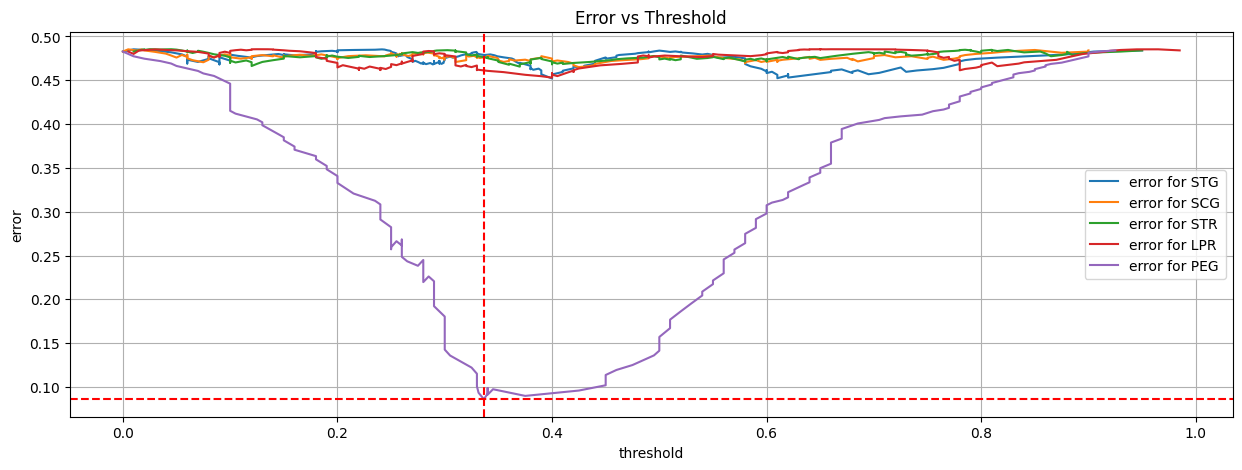

In [ ]:
plt.figure(figsize=(15, 5))
ans = np.inf
for col in X.columns:
    thrs, gns, best_th, best_c = find_best_split(X[col].values, y, task="classification", feature_type="real")
    plt.plot(thrs, gns, label=f"error for {col}")

    if best_c <= ans:
        ans = best_c

        best_thrs = best_th
        best_col = col

print(f'Best split feature for first node is {best_col}')
print(f'Best threshold is {best_thrs}')
plt.xlabel("threshold")
plt.ylabel("error")
plt.axvline(best_thrs, color='r', linestyle='--')
plt.axhline(ans, color='r', linestyle='--')
plt.grid()
plt.legend()
plt.title("Error vs Threshold")
plt.show()

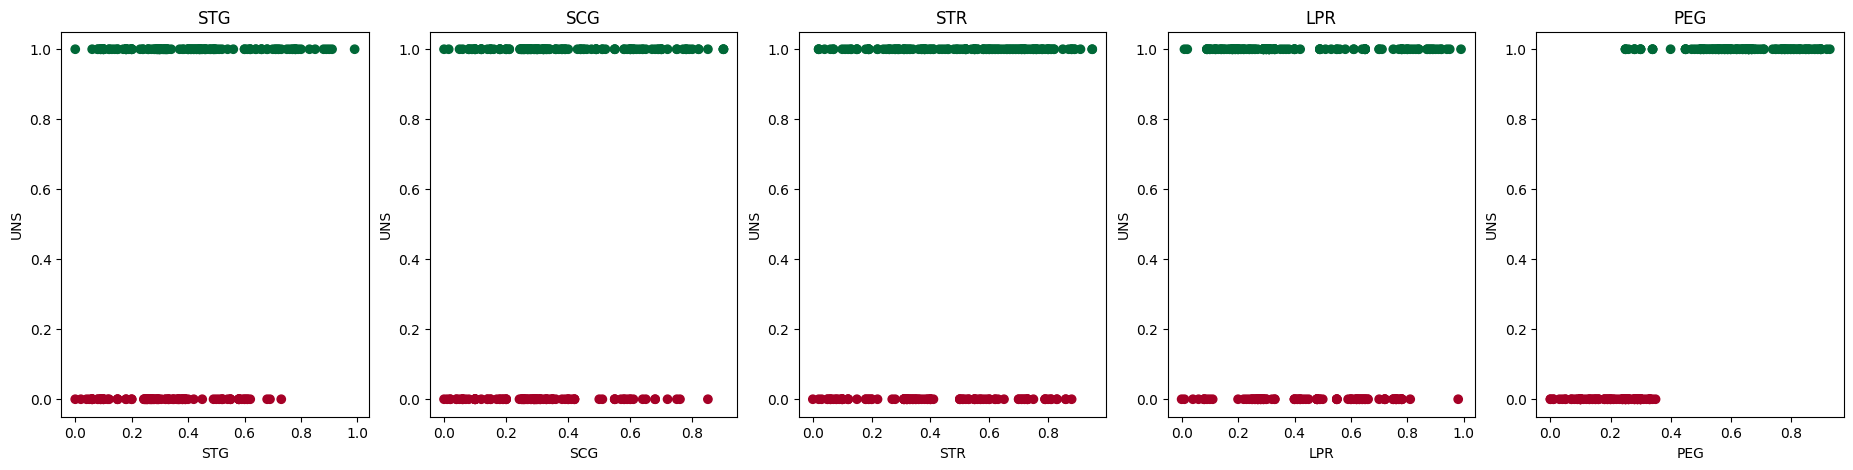

In [ ]:
fig = plt.subplots(1, len(X.columns), figsize=(23, 5))
for i, col in enumerate(X.columns):
    plt.subplot(1, len(X.columns), i+1)
    plt.scatter(X[col], y, c=y, cmap='RdYlGn')
    plt.xlabel(col)
    plt.ylabel('UNS')
    plt.title(col)

plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

---
**Ans:** Исходя из графика, нужно делить по PEG, что действительно сходится с логикой, если смотреть на распределение этого признака в зависимости от класса (данный признак получился "наиболее разделимым" среди всех остальных). Вид плохих и хороших кривых перкрасно иллюстрирует график ниже. То есть у  хорошо разделимой выбороки будет один глобальный минимум, как ниже. 

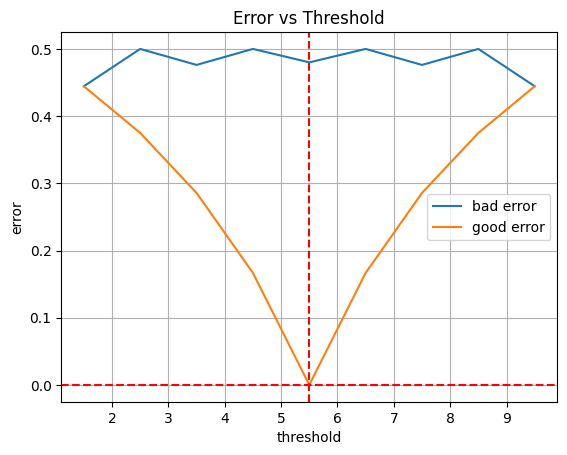

In [ ]:
data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
bad_y = np.array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1])
good_y = np.array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

all_data = [bad_y, good_y]
for yy in all_data:
    thrs, gns, best_th, best_c = find_best_split(data, yy, task="classification", feature_type="real")
    plt.plot(thrs, gns, label="bad error" if yy[0] == 0 else "good error")

plt.xlabel("threshold")
plt.ylabel("error")
plt.axvline(best_th, color='r', linestyle='--')
plt.axhline(best_c, color='r', linestyle='--')
plt.grid()
plt.legend()
plt.title("Error vs Threshold")
plt.show()

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [ ]:
data = pd.read_csv('agaricus-lepiota.data')
data.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in data.columns:
    data[col] = le.fit_transform(data[col])

X = data.drop(['p'], axis=1)
y = data['p']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

my_tree = DecisionTree(feature_types=['categorical' for _ in range(len(X.columns))])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
my_tree.fit(X_train.values, y_train.values)

y_pred = my_tree.predict(X_test.values)
acc_score = accuracy_score(y_test.values, y_pred)
print(f'Accuracy: {acc_score}')

Accuracy: 1.0


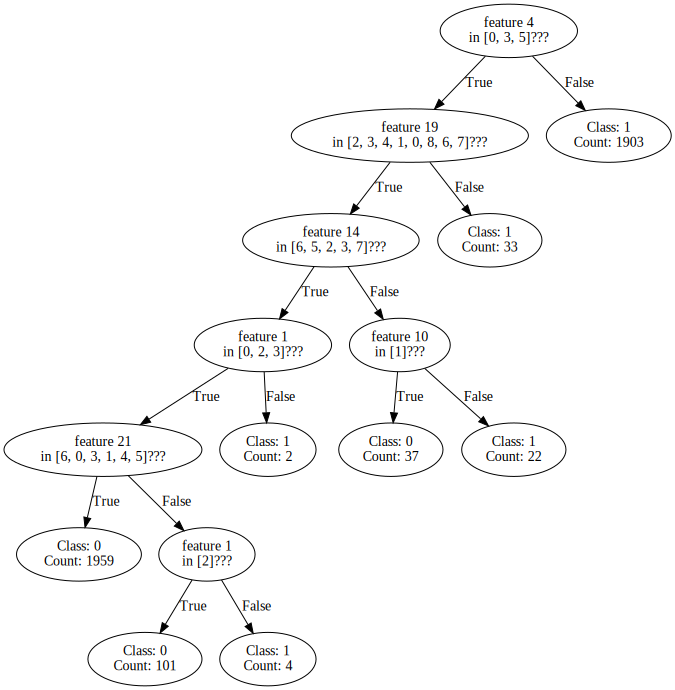

In [ ]:
#@title for picture of our tree
import graphviz

def draw_graph(node, dot=None):
    if dot is None:
        dot = graphviz.Digraph()

    if "class" in node:
        dot.node(str(id(node)), f'Class: {node["class"]}\n Count: {node["counts"]}')
    else:
        dot.node(str(id(node)), "feature " + str(node["feature_split"]) + f'\n in {node["categories_split"]}???' )
        
        left_child = node["left_child"]
        right_child = node["right_child"]

        dot.edge(str(id(node)), str(id(left_child)), label="True")
        dot.edge(str(id(node)), str(id(right_child)), label="False")

        draw_graph(left_child, dot)
        draw_graph(right_child, dot)

    return dot

tree = my_tree.tree_data()

dot = draw_graph(tree)
dot.render("tree", format="png", view=True)
dot

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [ ]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

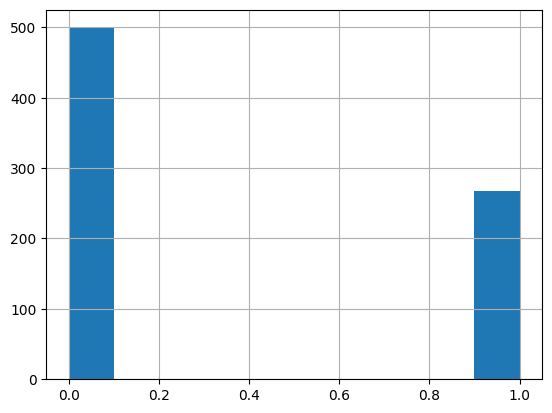

In [ ]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [ ]:
X = data.drop(['Outcome'], axis=1)
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [ ]:
max_depthes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
min_samples_leafs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

scores = []
for max_depth in max_depthes:
    for min_samples_leaf in min_samples_leafs:
        tree = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        tree.fit(X_val.values, y_val.values)
        y_pred = tree.predict(X_val.values)

        score = f1_score(y_val.values, y_pred)
        scores.append([score, max_depth, min_samples_leaf])

scores = np.array(scores).astype(int)
best_params = scores[np.argmax(scores[:, 0])]

In [ ]:
_, max_depth, min_samples_leaf = best_params
print(f'Best max_depth is {max_depth}')
print(f'Best min_samples_leaf is {min_samples_leaf}')

Best max_depth is 9
Best min_samples_leaf is 1


In [ ]:
tree = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
tree.fit(X_train.values, y_train.values)

y_pred = tree.predict(X_test.values)

print(classification_report(y_test.values, y_pred))
print(f' ROC AUC score is {roc_auc_score(y_test.values, y_pred)}')

              precision    recall  f1-score   support

           0       0.82      0.72      0.77       151
           1       0.57      0.71      0.63        80

    accuracy                           0.71       231
   macro avg       0.70      0.71      0.70       231
weighted avg       0.74      0.71      0.72       231

 ROC AUC score is 0.7138658940397351


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [ ]:
tree = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
bag = BaggingClassifier(estimator=tree, n_estimators=50, random_state=42)

bag.fit(X_train.values, y_train.values)

y_pred = bag.predict(X_test.values)
print(classification_report(y_test.values, y_pred))
print(f' ROC AUC score is {roc_auc_score(y_test.values, y_pred)}')

              precision    recall  f1-score   support

           0       0.83      0.79      0.81       151
           1       0.63      0.69      0.66        80

    accuracy                           0.75       231
   macro avg       0.73      0.74      0.73       231
weighted avg       0.76      0.75      0.76       231

 ROC AUC score is 0.7377897350993378


Качество улучшилось почти по всем метрикам.

**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [ ]:
from sklearn.model_selection import cross_validate

max_depthes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
min_samples_leafs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
cv = 5

def scoring(y_true, y_pred):
    return f1_score(y_true, y_pred)

scores = np.zeros((len(max_depthes), len(min_samples_leafs), cv))
for i, max_depth in enumerate(max_depthes):
    for j, min_samples_leaf in enumerate(min_samples_leafs):
        forest = RandomForestClassifier(n_estimators=50, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
        res = cross_validate(forest, X_train.values, y_train, scoring='f1', cv=cv)
        scores[i, j, :] = res['test_score']
        
scores = np.mean(scores, axis=2)

In [ ]:
scores.shape

(20, 20)

In [ ]:
best_index = np.unravel_index(np.argmax(scores, axis=None), scores.shape)
best_md = max_depthes[best_index[0]]
best_msl = min_samples_leafs[best_index[1]]

best_md, best_msl, scores[best_index]

(13, 1, 0.6533438117808859)

In [ ]:
forest = RandomForestClassifier(n_estimators=50, max_depth=best_md, min_samples_leaf=best_msl, random_state=42)
forest.fit(X_train.values, y_train.values)

y_pred = forest.predict(X_test.values)
print(classification_report(y_test.values, y_pred))
print(f' ROC AUC score is {roc_auc_score(y_test.values, y_pred)}')

              precision    recall  f1-score   support

           0       0.82      0.80      0.81       151
           1       0.64      0.68      0.66        80

    accuracy                           0.76       231
   macro avg       0.73      0.74      0.74       231
weighted avg       0.76      0.76      0.76       231

 ROC AUC score is 0.7381622516556291


Качество чуть-чуть ухудшилось

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

In [ ]:
n_estimatorsS = np.arange(10, 1000, 5)

auci = []
for n_estimators in n_estimatorsS:
    forest_x_forest = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    forest_x_forest.fit(X_train.values, y_train.values)
    y_pred = forest_x_forest.predict(X_test.values)

    auci.append(roc_auc_score(y_test.values, y_pred))

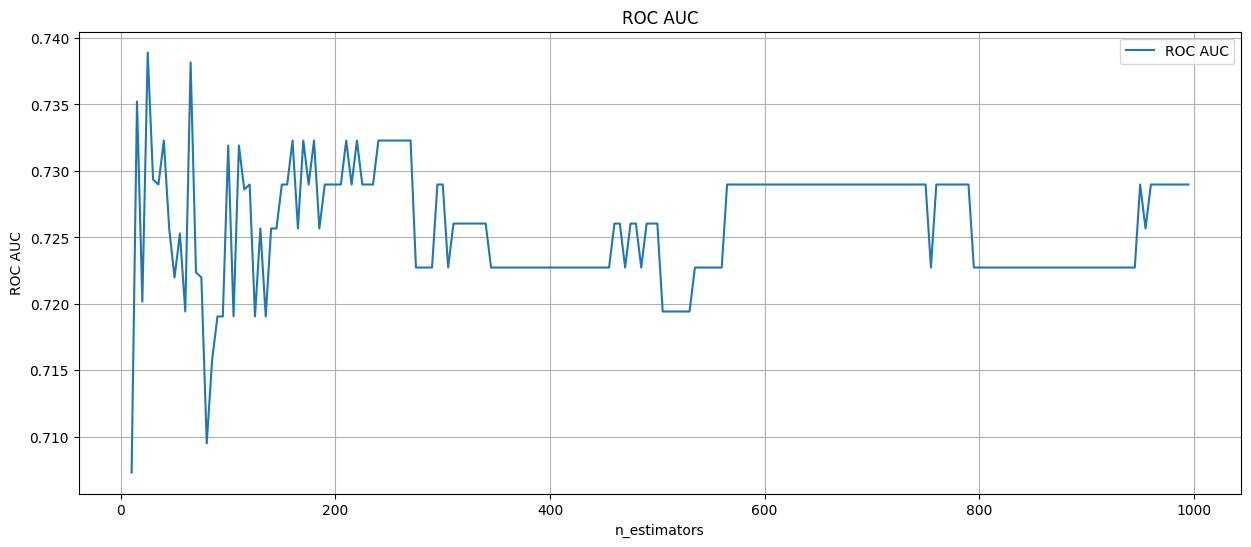

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(n_estimatorsS, auci, label='ROC AUC')
plt.grid()
plt.title('ROC AUC')
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('ROC AUC')
plt.show()

Выводы можно сделать неоднозначные). Но видно, что в начале метрика достигает максимума, потом есть провал и дальше происходят некоторые колебания.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

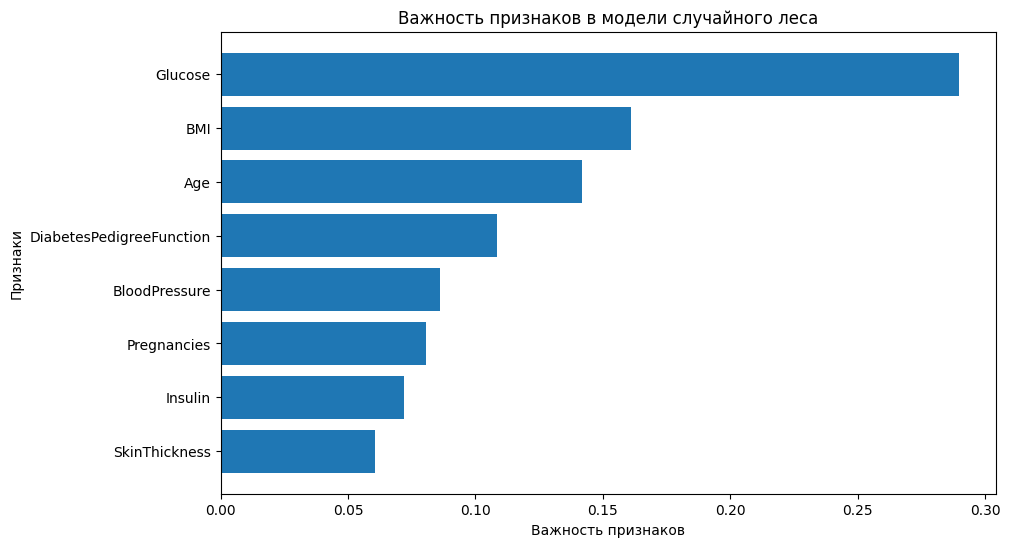

In [ ]:
importances = forest.feature_importances_

sorted_indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.barh(range(X.shape[1]), importances[sorted_indices], align='center')
plt.yticks(range(X.shape[1]), X.columns[sorted_indices])
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title('Важность признаков в модели случайного леса')
plt.show()

Количество глюкозы оказалось наиболее важным.